In [1]:
import os
import librosa
import numpy as np
from tensorflow.keras.utils import to_categorical
from scipy.stats import skew

# Function to extract features from an audio file (you may need to adjust it based on your feature extraction method)
def extract_features(file_path):
    y, sr = librosa.load(file_path)

    # Extract Mel-Frequency Cepstral Coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Extract Chroma feature
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # Extract Spectral Contrast feature
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # Concatenate the features
    features = np.vstack([mfccs, chroma, contrast])

    return features

# Function to create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

# Directory path where your dataset is located
dataset_path = '../data/audio'

# Initialize lists to store data and labels
data = []
labels = []

# Parameters
sequence_length = 50  # Adjust as needed
num_classes = len(os.listdir(dataset_path))

# Iterate through each class folder
for class_index, class_folder in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_folder)

    # Iterate through each audio file in the class folder
    for audio_file in os.listdir(class_path):
        audio_path = os.path.join(class_path, audio_file)

        # Extract features from the audio file
        features = extract_features(audio_path)

        # Create sequences from the features
        sequences = create_sequences(features.T, sequence_length)

        # Append sequences and corresponding label to the lists
        data.extend(sequences)
        labels.extend([class_index] * len(sequences))

# Convert to numpy arrays
data = np.array(data)
labels = to_categorical(labels, num_classes=num_classes)

# Shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

data.shape

c:\Users\burjo\miniconda3\envs\speech\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


(7, 50, 32)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Build an LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(units=25, input_shape=(X_train.shape[1]//2, X_train.shape[2]//2), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=labels.shape[1], activation='softmax'))


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Reduce learning rate if the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Save the trained model
model.save('../app/models/lstm_model.h5')


ValueError: Input 0 of layer "lstm_7" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)

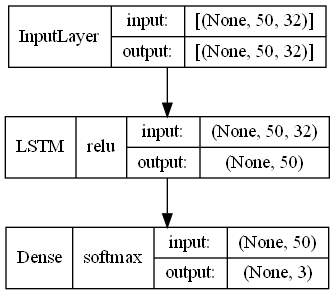

In [3]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)

# 4

In [2]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Set the path to the dataset directory
data_dir = '../data/recorded_audio'

# Define the parameters for the MFCC extraction
n_mfcc = 13
n_fft = 2048
hop_length = 512

# Function to extract MFCCs from an audio file, ensuring all outputs have the same length
def extract_mfcc(file_path, max_pad_length):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    # Pad or truncate the number of columns to max_pad_length
    if mfccs.shape[1] < max_pad_length:
        # Pad with zeros
        mfccs = np.pad(mfccs, ((0, 0), (0, max_pad_length - mfccs.shape[1])), constant_values=(0))
    else:
        # Truncate the excess
        mfccs = mfccs[:, :max_pad_length]
    return mfccs.T

# Determine the maximum length of MFCC columns among all audio files
max_length = 0
for label in os.listdir(data_dir):
    subdir = os.path.join(data_dir, label)
    for file_name in os.listdir(subdir):
        file_path = os.path.join(subdir, file_name)
        audio, _ = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=audio, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        if mfccs.shape[1] > max_length:
            max_length = mfccs.shape[1]

# Initialize lists for features and labels
features = []
labels = []

# Loop through all the classes and files; extract features
for label in os.listdir(data_dir):
    subdir = os.path.join(data_dir, label)
    for file_name in os.listdir(subdir):
        file_path = os.path.join(subdir, file_name)
        mfccs = extract_mfcc(file_path, max_length)
        features.append(mfccs)
        labels.append(label)

# Encode the labels into integers
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# One-hot encode the integer labels
one_hot_labels = to_categorical(encoded_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(features), one_hot_labels, test_size=0.2, random_state=42)

# Normalize the feature data
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Reshape the data for LSTM (samples, time steps, features)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Display the shape of the processed data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


C:\Users\burjo\AppData\Local\Temp\ipykernel_14296\150675127.py:35: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(file_path, sr=None)
c:\Users\burjo\miniconda3\envs\speech\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\burjo\AppData\Local\Temp\ipykernel_14296\150675127.py:18: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, sr=None)


(127, 181, 13, 1) (32, 181, 13, 1) (127, 3) (32, 3)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model architecture
model = Sequential()

# Add LSTM layers
# Note: 'return_sequences=True' is necessary for stacking LSTM layers except for the last LSTM layer.
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense layer with as many neurons as categories and softmax activation
model.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# After training, you can evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 181, 64)           19968     
                                                                 
 dropout (Dropout)           (None, 181, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 53,187
Trainable params: 53,187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4/4 [==============================] - 8s

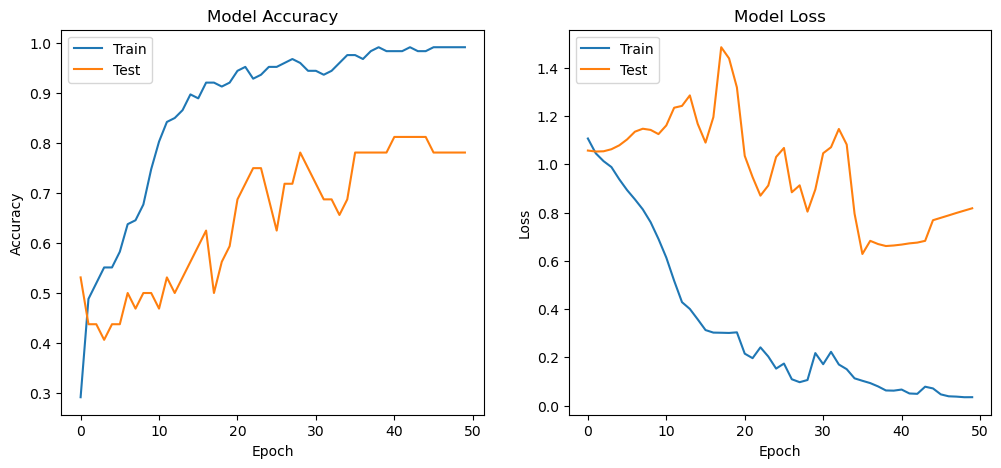

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

1/1 [==============================] - 1s 1s/step


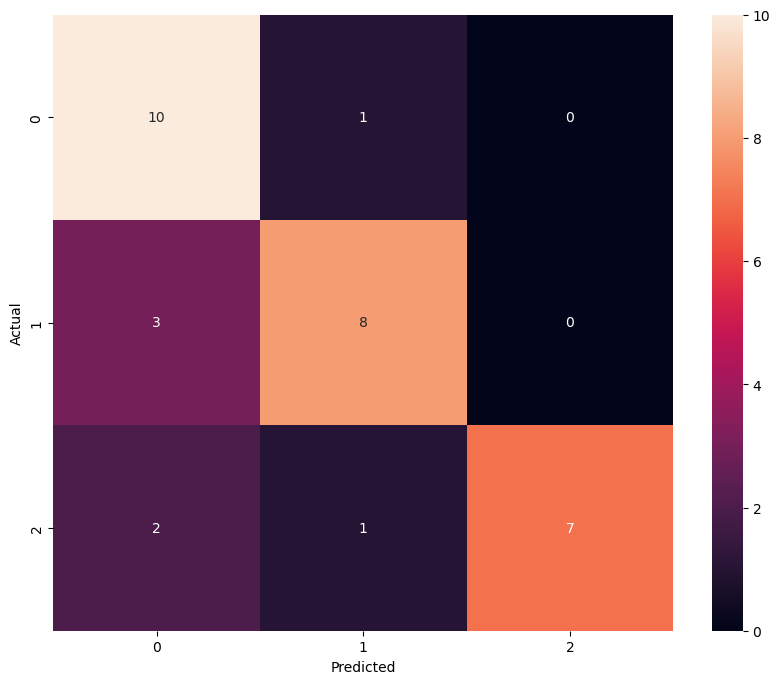

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the values from the test dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert test observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 
# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define a simpler LSTM model_simpler architecture
model_simpler = Sequential()

# Add a single LSTM layer with fewer units
model_simpler.add(LSTM(units=32, input_shape=(X_train.shape[1], X_train.shape[2])))
model_simpler.add(Dropout(0.2))

# Add a Dense layer with as many neurons as there are classes
model_simpler.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model_simpler
model_simpler.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model_simpler
model_simpler.summary()

# Train the model_simpler
history = model_simpler.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model_simpler on the test set
test_loss, test_accuracy = model_simpler.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                5888      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 5,987
Trainable params: 5,987
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4/4 [==============================] - 4s 367ms/step - loss: 1.1727 - accuracy: 0.2598 - val_loss: 1.0981 - val_accuracy: 0.3750
Epoch 2/30
4/4 [==============================] - 0s 103ms/step - loss: 1.1524 - accuracy: 0.2677 - val_loss: 1.0925 - val_accuracy: 0.4062
Epoch 3/30
4/4 [====================

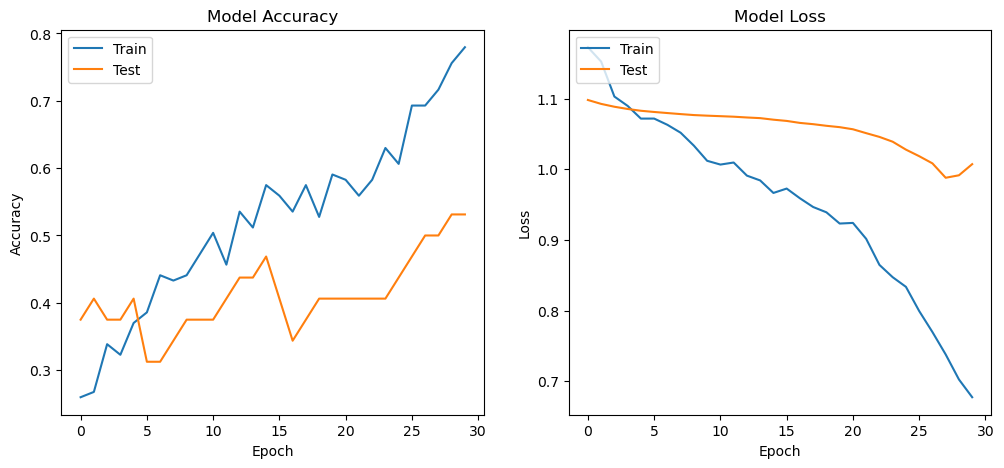

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the Bidirectional LSTM architecture
model_bi = Sequential()

# Add the first Bidirectional LSTM layer
model_bi.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bi.add(Dropout(0.2))

# Add the second Bidirectional LSTM layer
model_bi.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model_bi.add(Dropout(0.2))

# Add a Dense layer with as many neurons as there are classes with softmax activation
model_bi.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
model_bi.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model_bi.summary()

# Train the model
history_bi = model_bi.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model_bi.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 181, 128)         39936     
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 181, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 139,139
Trainable params: 139,139
Non-tr

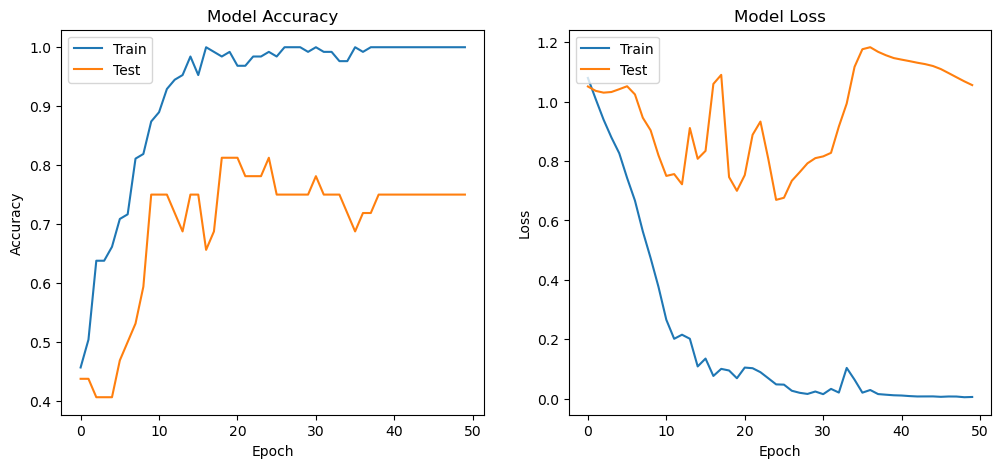

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bi.history['accuracy'])
plt.plot(history_bi.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_bi.history['loss'])
plt.plot(history_bi.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

# Define the Bidirectional LSTM architecture
model_bi2 = Sequential()

# Add the first Bidirectional LSTM layer
model_bi2.add(Bidirectional(LSTM(units=64, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bi2.add(Dropout(0.2))

# Add the second Bidirectional LSTM layer
model_bi2.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model_bi2.add(Dropout(0.2))

# Add a Dense layer with as many neurons as there are classes with softmax activation
model_bi2.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
model_bi2.compile(optimizer=Adam(learning_rate=0.0005, clipvalue=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model_bi2.summary()

# Add EarlyStop callback 
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_bi2 = model_bi2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model_bi2.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 181, 128)         39936     
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 181, 128)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 139,139
Trainable params: 139,139
Non-tr

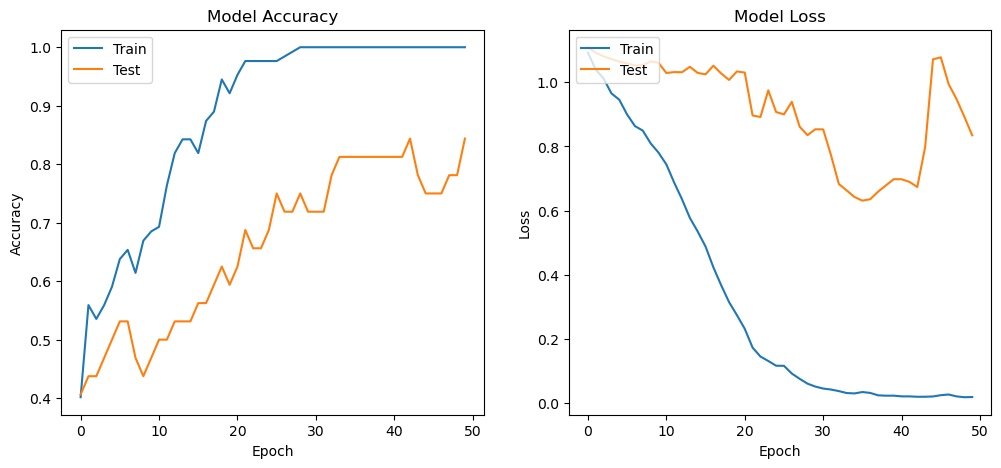

: 

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bi2.history['accuracy'])
plt.plot(history_bi2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_bi2.history['loss'])
plt.plot(history_bi2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Define the Bidirectional LSTM architecture
model_bi3 = Sequential()

# Add the first Bidirectional LSTM layer
model_bi3.add(Bidirectional(LSTM(units=80, return_sequences=True, recurrent_dropout=0.2), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bi3.add(Dropout(0.2))

# Add the second Bidirectional LSTM layer
model_bi3.add(Bidirectional(LSTM(units=80, return_sequences=False, recurrent_dropout=0.2)))
model_bi3.add(Dropout(0.2))

# Add a Dense layer with as many neurons as there are classes with softmax activation
model_bi3.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
model_bi3.compile(optimizer=Adam(learning_rate=0.001, clipvalue=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model_bi3.summary()

# Add callback 
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history_bi3 = model_bi3.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=lr_scheduler)

# Evaluate the model on the test set
test_loss, test_accuracy = model_bi3.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 181, 160)         60160     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 181, 160)          0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 160)              154240    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 160)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 483       
                                                                 
Total params: 214,883
Trainable params: 214,883
Non-tr

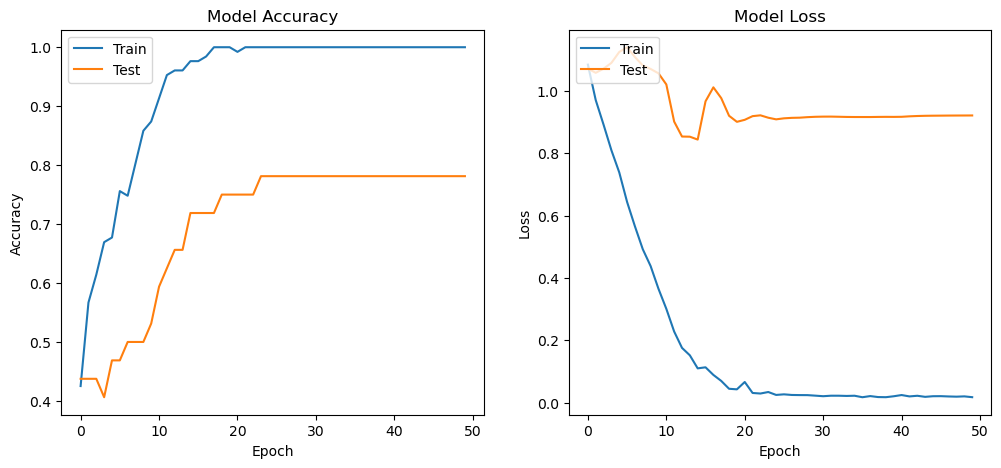

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bi3.history['accuracy'])
plt.plot(history_bi3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_bi3.history['loss'])
plt.plot(history_bi3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the Bidirectional LSTM model architecture
model = Sequential()

# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=64, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Add a Dense layer with as many neurons as there are classes with softmax activation
model.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 128)              39936     
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 40,323
Trainable params: 40,323
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4/4 [==============================] - 5s 452ms/step - loss: 1.0919 - accuracy: 0.3937 - val_loss: 1.0629 - val_accuracy: 0.3750
Epoch 2/50
4/4 [==============================] - 1s 137ms/step - loss: 1.0313 - accuracy: 0.4646 - val_loss

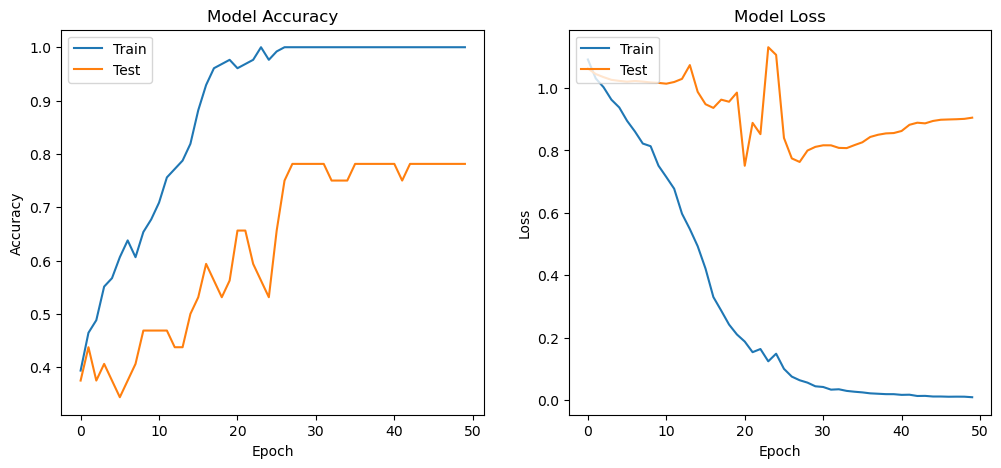

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the simple LSTM model architecture
model_simple = Sequential()

# Add a single LSTM layer with a small number of units
model_simple.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2])))
model_simple.add(Dropout(0.5))  # Increase dropout for regularization

# Add a Dense layer with as many neurons as there are classes with softmax activation
model_simple.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model with a potentially larger learning rate to speed up training
model_simple.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model_simple.summary()

# Train the model with early stopping and a smaller batch size for more updates
history_simple = model_simple.fit(
    X_train, y_train,
    epochs=100,  # Increase the number of epochs
    batch_size=16,  # Smaller batch size for more updates
    validation_data=(X_test, y_test),
    # callbacks=[
    #     EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Early stopping to prevent overfitting
    # ]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_simple.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 16)                1920      
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 51        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 3s 144ms/step - loss: 1.1261 - accuracy: 0.3701 - val_loss: 1.1015 - val_accuracy: 0.3438
Epoch 2/100
8/8 [==============================] - 0s 62ms/step - loss: 1.1020 - accuracy: 0.4094 - val_loss: 1.0876 - val_accuracy: 0.4062
Epoch 3/100
8/8 [=================

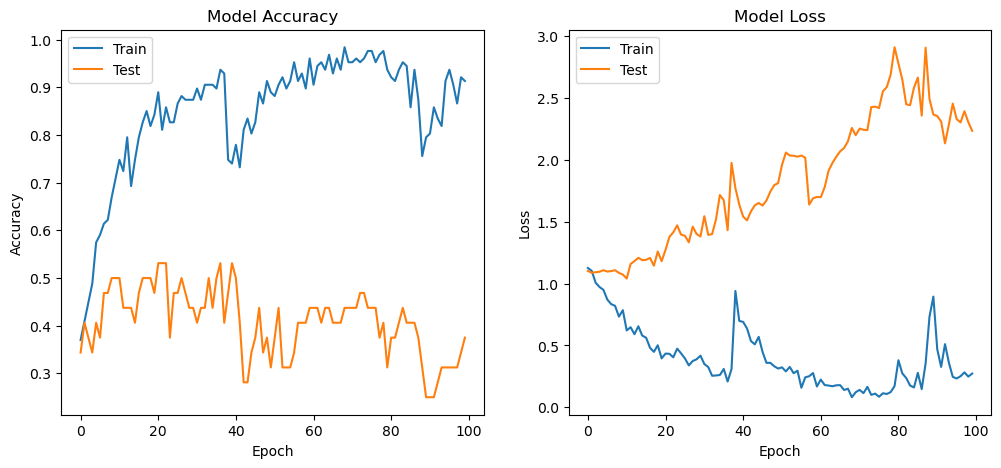

: 

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_simple.history['accuracy'])
plt.plot(history_simple.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()